# Complex Bayesian Network notebook

#### Import dependencies

In [1]:
# Import dependencies
#%pip install pgmpy
#%pip install tabulate
#%pip install pandas
#%pip install networkx
#%pip install matplotlib

#### Load libraries

In [2]:
# Load libraries
import pgmpy as pg
import tabulate as tb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Data import and cleaning

#### Import BigPerf data

In [3]:
# Import data
df = pd.read_csv("C:\\Users\\Keir McGlinn-Shaw\\Documents\\Stage-3\\Dissertation\\Data\\Use\\BigPerfMetrics.csv")

df.head()

,Block_ID,HDFS_BW,HDFSTranmissionTime,Mapper_ID,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_ID,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_ID.1,Block_BW,BlockTransmissionTime,TransactionTime
0,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer0,341739,480,3.80,250.14,reducer0_Block_1,0.0,0.00,1578.79
1,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer1,150000,120,50.00,18.99,reducer1_Block_1,50.0,20.00,1007.64
2,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer2,382530,480,4.48,212.22,reducer2_Block_1,3.7,270.02,1811.61
3,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer3,150000,120,5.88,161.57,reducer3_Block_1,3.7,270.02,1400.96
4,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,18.41,4.16,reducer4,457419,480,5.88,161.53,reducer4_Block_1,3.7,270.02,1761.83


#### Clean data of unwanted variables and missing values

In [4]:
# Clean data
df.dropna()

df.drop(labels=['Block_ID', 'Mapper_ID', 'Reducer_ID', 'Block_ID.1'], axis=1, inplace=True)

df.head()

,HDFS_BW,HDFSTranmissionTime,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_BW,BlockTransmissionTime,TransactionTime
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83


#### Rename columns to better fit in drawn charts and for ease of use

In [5]:
# Rename column headers to abbreviations

nodes = ['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT', 'TT']

df.columns = nodes

df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83
5,11.81,80.63,652289,765.49,18.41,4.16,150000,120,6.98,136.24,3.7,270.02,1376.54
6,11.81,80.63,652289,765.49,18.41,4.16,563904,480,3.80,250.14,3.7,270.02,1850.44
7,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63
8,11.81,80.63,652289,765.49,18.41,4.16,430890,480,3.80,250.14,3.7,270.02,1850.44
9,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63


#### Define funtion to discretise data into three catagories

In [6]:
'''
Splits data into three bins of equal size using: https://pandas.pydata.org/docs/reference/api/pandas.cut.html
'''
def split_tertiles(df):
    tertile_labels = ['Low', 'Medium', 'High']

    tert_df = pd.DataFrame()

    for column_name in df:
        tert_df[column_name] = pd.cut(df[column_name], 3, labels=tertile_labels, ordered=True)

    # Change type of values stored in dataframe to avoid errors arrising from using the Category type when the dataframe is fed into the pgmpy.metrics.metrics correlation_score function
    tert_df = tert_df.astype('object')

    return tert_df

#### Discretise data into catagories

In [7]:
cat_df = split_tertiles(df)

cat_df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,High,Low,Low,Low,High,Low,Medium,High,Low,High,Low,Low,Low
1,High,Low,Low,Low,High,Low,Low,Low,Low,Low,High,Low,Low
2,High,Low,Low,Low,Medium,Low,Medium,High,Low,High,Low,High,Medium
3,High,Low,Low,Low,Medium,Low,Low,Low,Low,Medium,Low,High,Low
4,High,Low,Low,Low,Medium,Low,High,High,Low,Medium,Low,High,Medium
5,High,Low,Low,Low,Medium,Low,Low,Low,Low,Medium,Low,High,Low
6,High,Low,Low,Low,Medium,Low,High,High,Low,High,Low,High,Medium
7,High,Low,Low,Low,Medium,Low,Low,Low,High,Low,Low,High,Low
8,High,Low,Low,Low,Medium,Low,High,High,Low,High,Low,High,Medium
9,High,Low,Low,Low,Medium,Low,Low,Low,High,Low,Low,High,Low


In [8]:
from itertools import combinations

import networkx as nx
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from pgmpy.models import BayesianModel, NaiveBayes
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.estimators.CITests import chi_square, cressie_read, freeman_tuckey, g_sq, independence_match, log_likelihood
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling

In [9]:
pc = PC(data=cat_df)
model = pc.estimate(variant='parallel', ci_test=chi_square, return_type='dag', significance_level=0.60  )

Working for n conditional variables: 5: 100%|██████████| 5/5 [03:51<00:00, 70.57s/it]C:\ProgramData\Anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 5: 100%|██████████| 5/5 [06:58<00:00, 83.80s/it]
C:\ProgramData\Anaconda3\lib\site-packages\pgmpy\base\DAG.py:1008: UserWarning: PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
  warn(


In [11]:
bayes_model = BayesianModel(model.edges)

In [12]:
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML

# disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

bayes_model.cpds = []

bayes_model.fit(data=cat_df,
    estimator=BayesianEstimator,
    prior_type='BDeu',
    complete_samples_only=False)

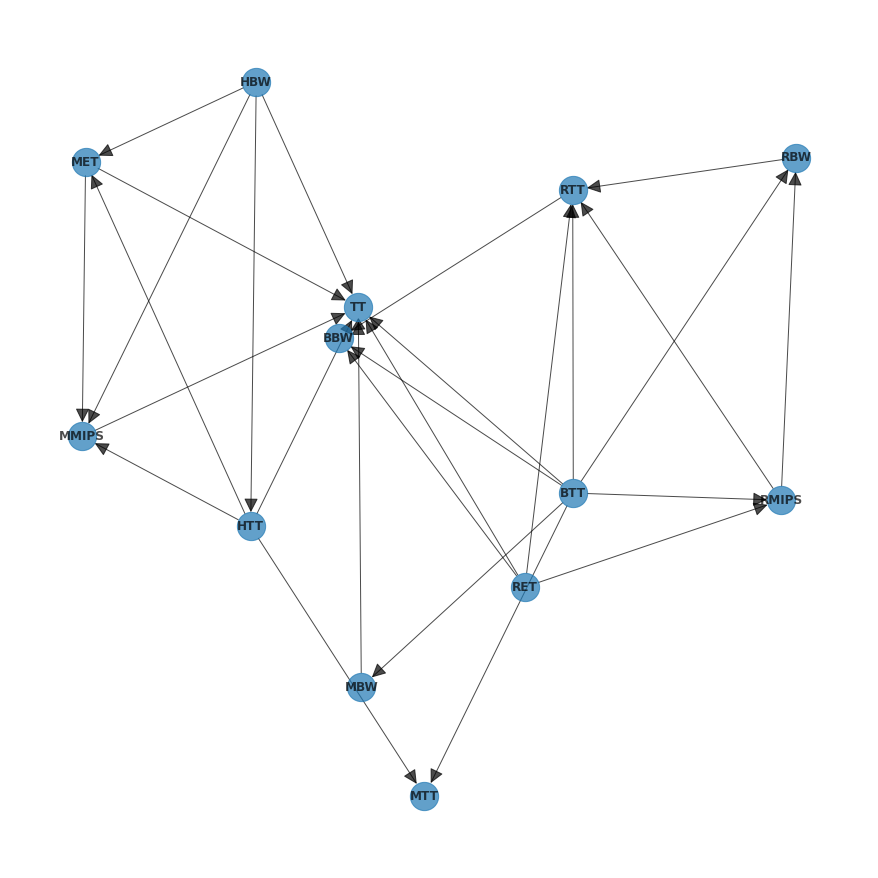

In [13]:
plt.figure(3,figsize=(12,12)) 
G = nx.DiGraph()
G.add_edges_from(bayes_model.edges)
G.add_nodes_from(bayes_model.nodes)
pos = nx.kamada_kawai_layout(G)

nx.draw(G, pos=pos, with_labels=True, arrowsize=30, node_size=800, alpha=0.7, font_weight="bold")  # Draw the original graph
plt.show()

In [14]:
print(f'Check model: {bayes_model.check_model()}\n')
for cpd in bayes_model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPT of RMIPS:
+---------------+-----------------------+-----------------------+-----------------------+-----------------------+
| BTT           | BTT(High)             | BTT(High)             | BTT(Low)              | BTT(Low)              |
+---------------+-----------------------+-----------------------+-----------------------+-----------------------+
| RET           | RET(High)             | RET(Low)              | RET(High)             | RET(Low)              |
+---------------+-----------------------+-----------------------+-----------------------+-----------------------+
| RMIPS(High)   | 0.7494879986892767    | 0.0004096010485786844 | 0.0016323865491348353 | 0.0016323865491348355 |
+---------------+-----------------------+-----------------------+-----------------------+-----------------------+
| RMIPS(Low)    | 0.0004096010485786844 | 0.9991807979028428    | 0.0016323865491348353 | 0.9967352269017304    |
+---------------+-----------------------+--------------